In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jan  9 09:50:32 2020

@author: fernandr
"""
#cd /home/fernandr/Python_prog/Training/Medium-Data-Exploration/
import json
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
)

sales_team = pd.read_csv('./Medium-Data-Exploration/sales_team.csv')
order_leads = pd.read_csv('./Medium-Data-Exploration/order_leads.csv')
invoices = pd.read_csv('./Medium-Data-Exploration/invoices.csv')
sales_team.head(2)

,Sales Rep,Sales Rep Id,Company Name,Company Id
0,William Taylor,ZTZA0ZLYZR85PTUJ,Melancholy Social-Role,D0AUXPP07H6AVSGD
1,William Taylor,ZTZA0ZLYZR85PTUJ,Pee-Wee Pigeon,TJW99R4RWH02INII


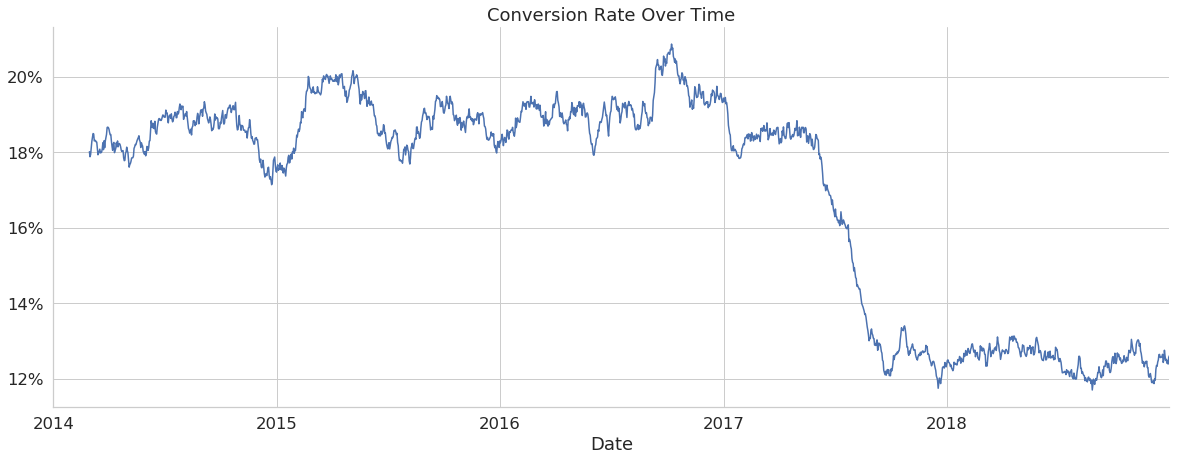

In [4]:
_ = order_leads.set_index(pd.DatetimeIndex(order_leads.Date)).groupby(
    pd.Grouper(freq='D')
)['Converted'].mean()

ax = _.rolling(60).mean().plot(figsize=(20,7),title='Conversion Rate Over Time')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}%'.format(x*100) for x in vals])
sns.despine()

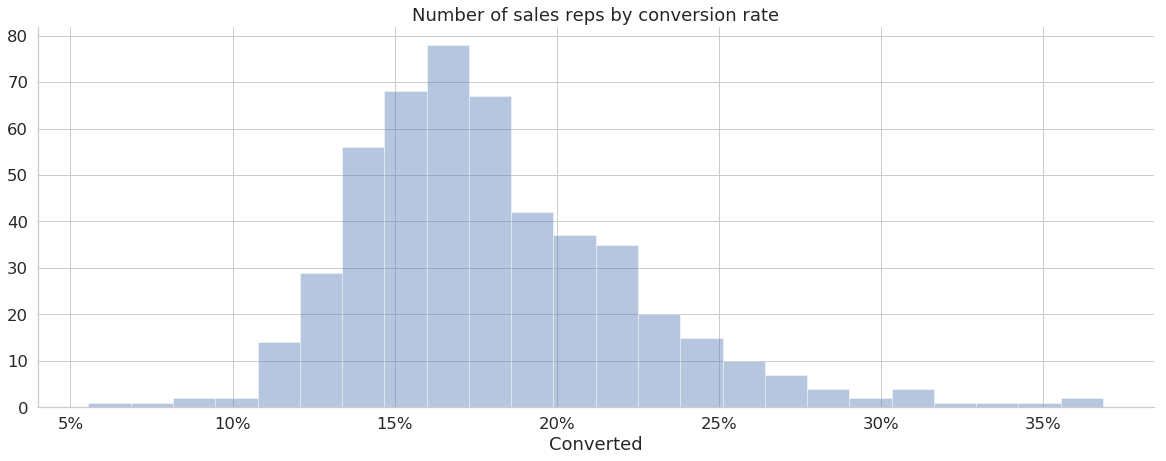

In [5]:
orders_with_sales_team = pd.merge(order_leads,sales_team,on=['Company Id','Company Name'])
ax = sns.distplot(orders_with_sales_team.groupby('Sales Rep Id')['Converted'].mean(),kde=False)
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0f}%'.format(x*100) for x in vals])
ax.set_title('Number of sales reps by conversion rate')
sns.despine()

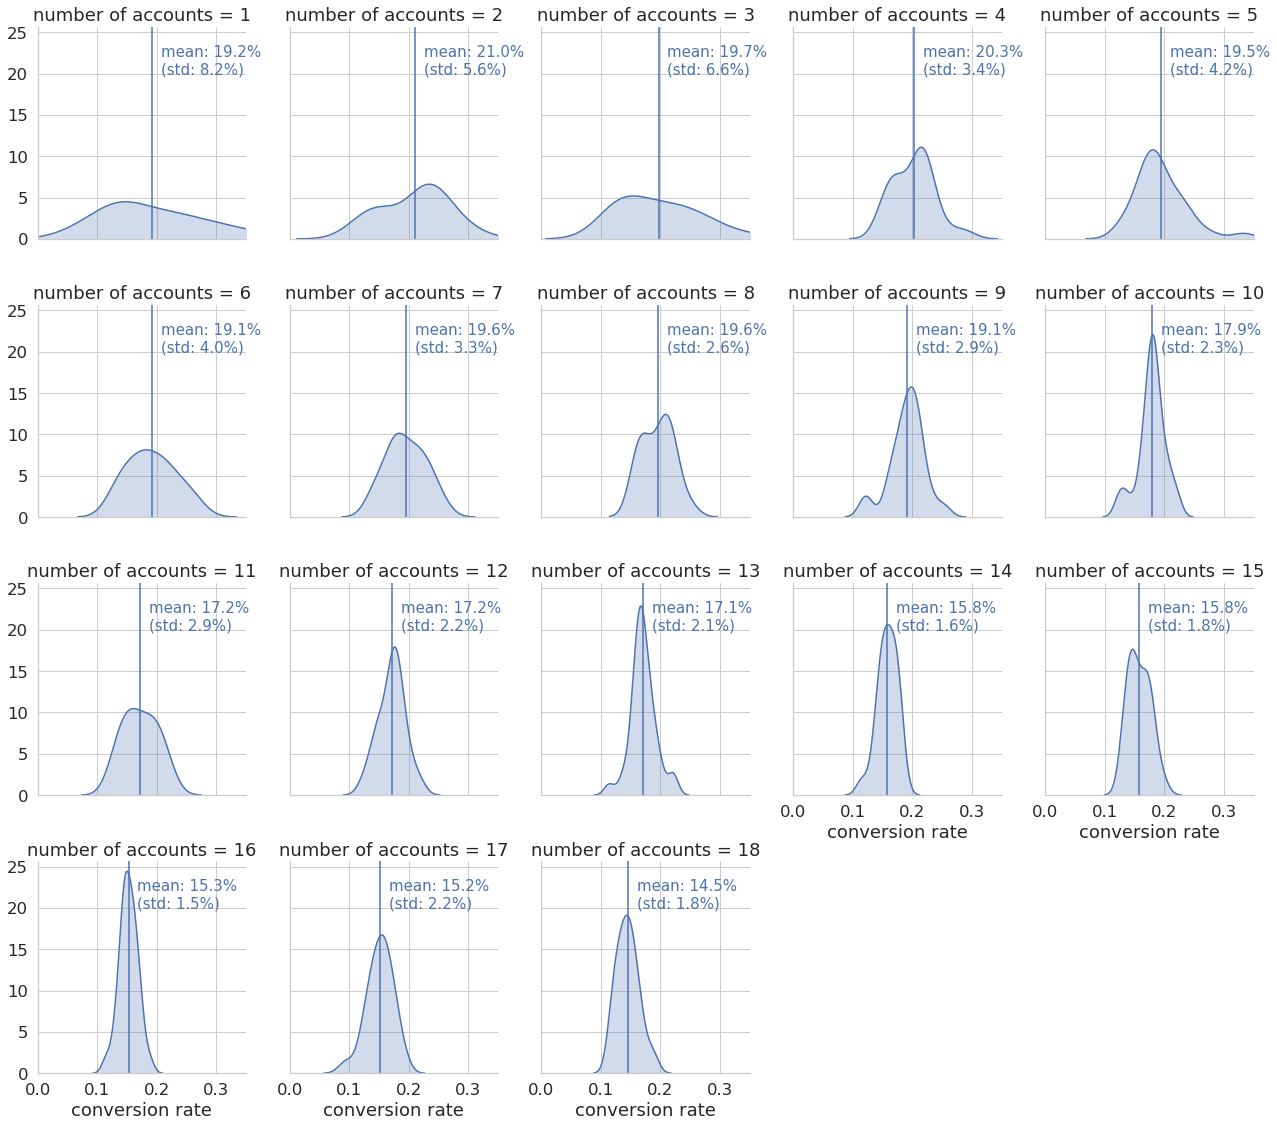

In [6]:
def vertical_mean_line(x, **kwargs):
    ls = {"0":"-","1":"--"}
    plt.axvline(x.mean(), linestyle =ls[kwargs.get("label","0")], 
                color = kwargs.get("color", "r"))
    txkw = dict(size=15, color = kwargs.get("color", "r"))
    tx = "mean: {:.1f}%\n(std: {:.1f}%)".format(x.mean()*100,x.std()*100)
    label_x_pos_adjustment = 0.015 
    label_y_pos_adjustment = 20
    plt.text(x.mean() + label_x_pos_adjustment, label_y_pos_adjustment, tx, **txkw)

sns.set(
    font_scale=1.5,
    style="whitegrid"
)

_ = orders_with_sales_team.groupby('Sales Rep Id').agg({
    'Converted': np.mean,
    'Company Id': pd.Series.nunique
})
_.columns = ['conversion rate','number of accounts']

g = sns.FacetGrid(_, col="number of accounts", height=4, aspect=0.9, col_wrap=5)
g.map(sns.kdeplot, "conversion rate", shade=True)
g.set(xlim=(0, 0.35))
g.map(vertical_mean_line, "conversion rate")

In [7]:
invoices['Date of Meal'] = pd.to_datetime(invoices['Date of Meal'])
invoices['Date of Meal'].dt.time.value_counts().sort_index()

07:00:00    5536
08:00:00    5613
09:00:00    5473
12:00:00    5614
13:00:00    5412
14:00:00    5633
20:00:00    5528
21:00:00    5534
22:00:00    5647
Name: Date of Meal, dtype: int64

In [9]:
invoices['Type of Meal'] = pd.cut(
    invoices['Date of Meal'].dt.hour,
    bins=[0,10,15,24],
    labels=['breakfast','lunch','dinner']
)

In [10]:
def replace(x):
    return x.replace("\n ",",").replace("' '","','").replace("'",'"')

invoices['Participants'] = invoices['Participants'].apply(lambda x: replace(x))
invoices['Number Participants'] = invoices['Participants'].apply(lambda x: len(json.loads(x)))

In [11]:
# combine order_leads with invoice data
orders_with_invoices = pd.merge(order_leads,invoices,how='left',on='Company Id')

# calculate days between order leads and invocies
orders_with_invoices['Days of meal before order'] = (
    pd.to_datetime(orders_with_invoices['Date']) - orders_with_invoices['Date of Meal']
).dt.days

# limit to only meals that are within 5 days of the order
orders_with_invoices = orders_with_invoices[abs(orders_with_invoices['Days of meal before order']) < 5]

# To mnake sure that we don't cross assign meals to multiple orders and therefore create duplicates
# we first sort our data by absolute distance to the orders
orders_with_invoices = orders_with_invoices.loc[
    abs(orders_with_invoices['Days of meal before order']).sort_values().index
]

# keep the first (i.e. closest to sales event) sales order
orders_with_invoices = orders_with_invoices.drop_duplicates(subset=['Order Id'])

orders_without_invoices = order_leads[~order_leads['Order Id'].isin(orders_with_invoices['Order Id'].unique())]

orders_with_meals = pd.concat([orders_with_invoices,orders_without_invoices],sort=True)

In [12]:
def plot_bars(data,x_col,y_col):
    data = data.reset_index()
    sns.set(
        font_scale=1.5,
        style="whitegrid",
        rc={'figure.figsize':(20,7)}
    )
    g = sns.barplot(x=x_col, y=y_col, data=data, color='royalblue')

    for p in g.patches:
        g.annotate(
            format(p.get_height(), '.2%'),
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', 
            va = 'center', 
            xytext = (0, 10), 
            textcoords = 'offset points'
        )
        
    vals = g.get_yticks()
    g.set_yticklabels(['{:,.0f}%'.format(x*100) for x in vals])

    sns.despine()

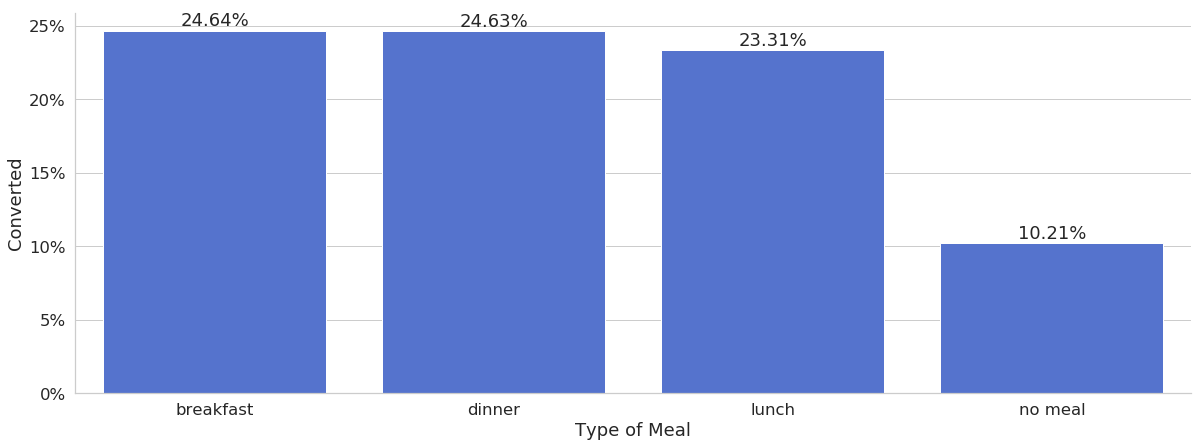

In [13]:
orders_with_meals['Type of Meal'].fillna('no meal',inplace=True)
_ = orders_with_meals.groupby('Type of Meal').agg({'Converted': np.mean})
plot_bars(_,x_col='Type of Meal',y_col='Converted')

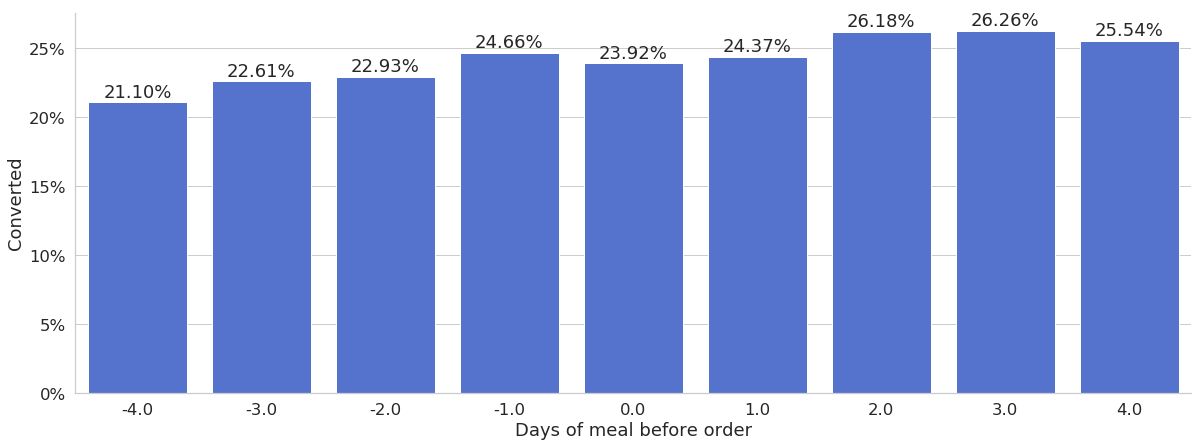

In [14]:
_ = orders_with_meals.groupby(['Days of meal before order']).agg(
    {'Converted': np.mean}
)
plot_bars(data=_,x_col='Days of meal before order',y_col='Converted')

In [15]:
def draw_heatmap(data,inner_row, inner_col, outer_row, outer_col, values):
    sns.set(font_scale=1)
    fg = sns.FacetGrid(
        data, 
        row=outer_row,
        col=outer_col, 
        margin_titles=True
    )

    position = left, bottom, width, height = 1.4, .2, .1, .6
    cbar_ax = fg.fig.add_axes(position) 

    fg.map_dataframe(
        draw_heatmap_facet, 
        x_col=inner_col,
        y_col=inner_row, 
        values=values, 
        cbar_ax=cbar_ax,
        vmin=0, 
        vmax=.4
    )

    fg.fig.subplots_adjust(right=1.3)  
    plt.show()

def draw_heatmap_facet(*args, **kwargs):
    data = kwargs.pop('data')
    x_col = kwargs.pop('x_col')
    y_col = kwargs.pop('y_col')
    values = kwargs.pop('values')
    d = data.pivot(index=y_col, columns=x_col, values=values)
    annot = round(d,4).values
    cmap = sns.color_palette("RdYlGn",30)
    # cmap = sns.color_palette("PuBu",30) alternative color coding
    sns.heatmap(d, **kwargs, annot=annot, center=0, fmt=".1%", cmap=cmap, linewidth=.5)

In [16]:
# Aggregate the data a bit
orders_with_meals['Meal Price / Order Value'] = orders_with_meals['Meal Price']/orders_with_meals['Order Value']
orders_with_meals['Meal Price / Order Value'] = pd.qcut(
    orders_with_meals['Meal Price / Order Value']*-1,
    5,
    labels = ['Least Expensive','Less Expensive','Proportional','More Expensive','Most Expensive'][::-1]
)

orders_with_meals['Timing of Meal'] = pd.qcut(
    orders_with_meals['Days of meal before order'],
    3,
    labels = ['After Order','Around Order','Before Order']
)


data = orders_with_meals[orders_with_meals['Type of Meal'] != 'no meal'].groupby(
    ['Timing of Meal','Number Participants','Type of Meal','Meal Price / Order Value']
).agg({'Converted': np.mean}).unstack().fillna(0).stack().reset_index()

/home/fernandr/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


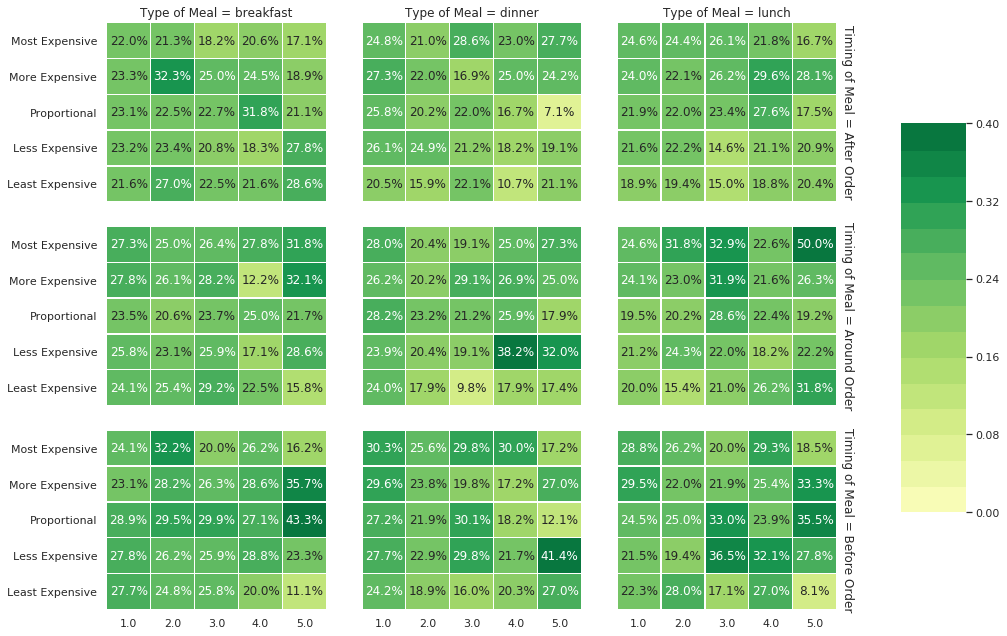

In [17]:
draw_heatmap(
    data=data, 
    outer_row='Timing of Meal',
    outer_col='Type of Meal',
    inner_row='Meal Price / Order Value',
    inner_col='Number Participants',
    values='Converted'
)